# Example Conversion Efficiency

This example simulates a single electrolyzer stack with a linear ramping power signal. The electrolyzer is initialized as ON. The full structure for an electrolyzer model is defined in the source code, in `modeling_schema.yaml`.

* Conversion is calculated based on the energy consumed per kg of hydrogen. Units are kWh/kg

* Conversion efficiency is calculated by dividing the high-heating value of hydrogen (39.39 kWh/kg) by the actual conversion.

In [17]:
import numpy as np

from electrolyzer import run_electrolyzer
from electrolyzer.inputs.validation import load_modeling_yaml

import matplotlib.pyplot as plt
%matplotlib inline

## Load Electrolyzer configuration from YAML file

This .yaml file initializes a 1.25MW electrolyzer stack as `ON` with the `BaselineDeg` controller. 

In [18]:
#fname_input_modeling = "./modeling_options_EnergieparkMainz.yaml"
fname_input_modeling = "./modeling_options.yaml"

model_input = load_modeling_yaml(fname_input_modeling)

rated_power = model_input['electrolyzer']['stack']['stack_rating_kW']
init_power = model_input['electrolyzer']['initial_power_kW']
n_stacks = model_input['electrolyzer']['control']['n_stacks']
# Linear ramping power signal [W]
power_signal_input = np.linspace(1.25e5 * n_stacks, 1.2e3 * rated_power * n_stacks, 2000)

#model_input["electrolyzer"]["control"]["n_stacks"] = 1
#model_input["electrolyzer"]["stack"]["max_current"] = 2500
#model_input["electrolyzer"]["stack"]["n_cells"] = 200

elec_sys, results_df = run_electrolyzer(model_input, power_signal_input)
#print(elec_sys.stacks[0].fit_params)
results_df.tail()



,power_signal,curtailment,kg_rate,stack_1_deg,stack_1_fatigue,stack_1_cycles,stack_1_uptime,stack_1_kg_rate,stack_1_curr_density
1995,1.497249e+06,0.247249,0.00527,6.000853e-07,0,0.0,1996.0,0.00527,1.805703
1996,1.497936e+06,0.247936,0.00527,6.004120e-07,0,0.0,1997.0,0.00527,1.805703
1997,1.498624e+06,0.248624,0.00527,6.007387e-07,0,0.0,1998.0,0.00527,1.805703
1998,1.499312e+06,0.249312,0.00527,6.010654e-07,0,0.0,1999.0,0.00527,1.805703
1999,1.500000e+06,0.250000,0.00527,6.013921e-07,0,0.0,2000.0,0.00527,1.805703


### Power Signal
* Linear ramp power signal 
* Confirm that the stack is initialized at time = 0.0 seconds

<AxesSubplot:title={'center':'Stack Up time'}, xlabel='Time (s)', ylabel='Time (s)'>

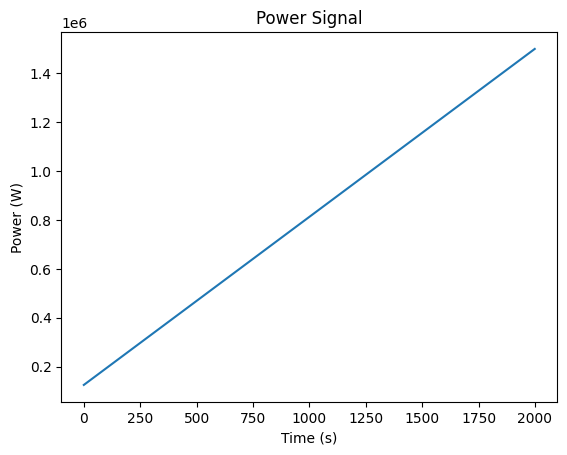

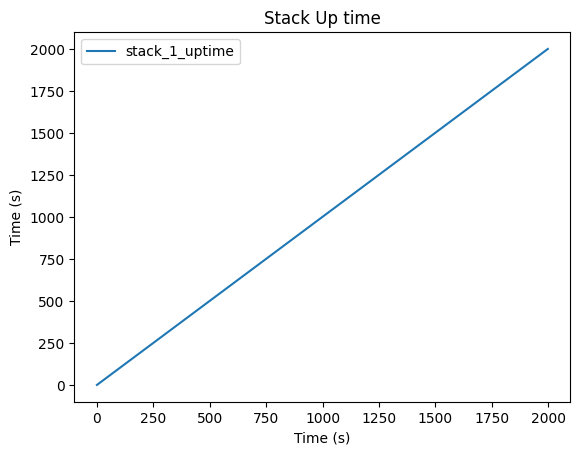

In [19]:
# Power input signal from DataFrame
results_df["power_signal"].plot(title="Power Signal", xlabel="Time (s)", ylabel="Power (W)")

# Plot stack up-time to show start up delays 
stack_uptime = results_df[[col for col in results_df.columns if "_uptime" in col]]
stack_uptime.plot(title="Stack Up time", xlabel="Time (s)", ylabel="Time (s)")

### Co-Plot H2 rate and Conversion Efficiency

* Converts DataFrame data to kW and kg/hr
* low-heating value (LHV) = 39.39 kWh/kg
* Rated power = 1.25MW per stack 

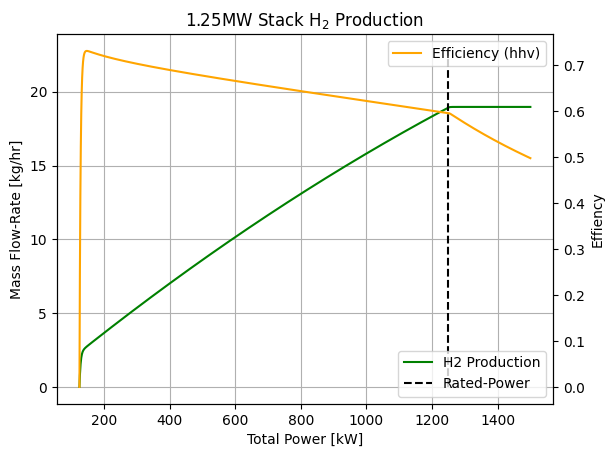

In [27]:
power_kW = results_df['power_signal'] / 1e3
h2rate_kg_hr = results_df['kg_rate'] * 3600

pressure_op = 101325
volrate_Nm3_hr = h2rate_kg_hr * 8.314 * (273.15 + 60) / 2.016 / pressure_op
#print(power_kW)
#print(h2rate_kg_hr)
hhv = 39.39
eff_conv = hhv * h2rate_kg_hr / power_kW 

fig, ax = plt.subplots()
ax.set_title('1.25MW Stack H$_{2}$ Production')
#ax.plot(power_kW, h2rate_kg_hr, label='H2 Production', color='green')
ax.plot(power_kW, h2rate_kg_hr, label='H2 Production', color='green')
ax.set_xlabel("Total Power [kW]")
ax.set_ylabel("Mass Flow-Rate [kg/hr]")
ax.vlines(x=rated_power, ymin=0, ymax=1.2*h2rate_kg_hr.max(), linestyle='dashed', color='black', label='Rated-Power')
plt.legend(loc='lower right')
plt.grid()
ax2 = ax.twinx()
ax2.plot(power_kW, eff_conv, color='orange', label='Efficiency (hhv)')
ax2.set_ylabel("Effiency")
plt.legend()


'\n450kg/day \n\nquestions from Maxx (how realistic is the model)\npart load efficiencies \ndegredation \nshutdowns \n3 days no wind? cold start?\n\n500ppm water per h2, is "dry hydrogen"? -> 99.95% purity \n10min delay/start up is sufficient for just the electrolyzer\n99.9% pure hydrogen at 30bar \nrelatively little standby power (controller and sensors)\nlargest passive load can be heaters if freezing conditions \n'

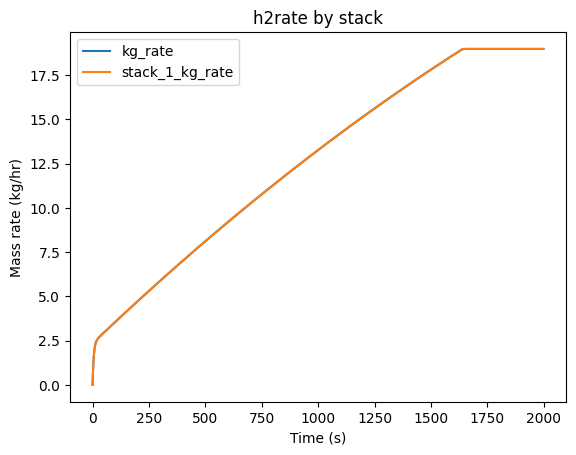

In [21]:
h2rate = results_df[[col for col in results_df.columns if "kg_rate" in col]] * 3600 
h2rate.plot(title="h2rate by stack", xlabel="Time (s)", ylabel="Mass rate (kg/hr)")

'''
450kg/day 

questions from Maxx (how realistic is the model)
part load efficiencies 
degredation 
shutdowns 
3 days no wind? cold start?

500ppm water per h2, is "dry hydrogen"? -> 99.95% purity 
10min delay/start up is sufficient for just the electrolyzer
99.9% pure hydrogen at 30bar 
relatively little standby power (controller and sensors)
largest passive load can be heaters if freezing conditions 
'''


